<a href="https://colab.research.google.com/github/tchamna/XGBOOST-Bike-Rental-Prediction/blob/main/Bike_Ride_sharing_Prediction_XGBoost_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem *Statement*

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

https://www.kaggle.com/competitions/bike-sharing-demand/data

# Import Libraries

In [ ]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import seaborn as sns


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error

# XGBoost 
import xgboost as xgb

In [ ]:
# os.remove(r"/content/sample_data")

from os import listdir

folder=os.listdir(os.getcwd())


for item in folder:
    if item.endswith(".txt") or item.endswith(".csv"):
        os.remove(item)

# Import Dataset

In [ ]:
dataset_path = "/content/drive/MyDrive/Data_Science/DataSets/bike-sharing-demand (2).zip"

import zipfile
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")


# Absolute path of a file
old_name = [r"/content/test.csv",r"/content/train.csv"]
new_name = [r"/content/bike_test.csv",r"/content/bike_train.csv"]

# Renaming the file
for i in range(len(old_name)):
  os.rename(old_name[i], new_name[i])

In [ ]:
# Specify the column names as the file does not have column header
df_train = pd.read_csv("bike_train.csv")

# df_validation = pd.read_csv(validation_file,names=columns)
df_test = pd.read_csv("bike_test.csv")
df_sample = pd.read_csv("sampleSubmission.csv")


df_train['datetime'] = df_train['datetime'].astype('datetime64[ns]') # Convert text/string to datatime
df_test['datetime'] = df_test['datetime'].astype('datetime64[ns]') # Convert text/string to datatime



df_train = df_train.set_index("datetime")
df_test = df_test.set_index("datetime")

data_train = df_train.copy() # Keep the original copy
data_test = df_test.copy() # Keep the original copy

#Explore the dataset

## Headers

In [ ]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
print("training shape:",df_train.shape)
print("test shape:",df_test.shape)

training shape: (10886, 11)
test shape: (6493, 8)


Notice that the test data does not have the <b>casual</b> field, nor the <b>registered</b> field. This means that these fields should not be used for training purpose.
We also do not have the <b>count</b>. This is normal because it is the field we want to predict. It is our Target Variable.

Also notice that the data is already given on an <b>hourly-basis</b>. So we are good, because we want to predict the count per hour. No need to recsample the data.

## Null (Nan) Values

In [ ]:
# Check for missing values
df_train.isnull().any()

season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

The above cell suggests that the training dataset does not have any missing value. But this is actually not the case because the problem states that from the 19 to the end of each month, data is missing! We need to aggregate/resample the data on a daily-basis to have a clear idea of what is going on here

## Data Types

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


The celle above shows that the intex of the dataset is already a DatetimeIndex, if not we would have needed to convert it into this format.

On the other hand, if we want to pull the datime field, we have to reset the index with <b>df.reset_index()</b>

In [ ]:

# df_train['datetime'] = df_train.reset_index()['datetime'].astype('datetime64[ns]') # Convert text/string to datatime
# df_test['datetime'] = df_test.reset_index()['datetime'].astype('datetime64[ns]') # Convert text/string to datatime


## Duplicates

In [ ]:
# Check for duplicate rows
df_train.duplicated().sum()

21

In [ ]:
duplicated = df_train[df_train.duplicated(subset=None, keep=False)]

print("duplicate shape:",duplicated.shape)

duplicated

duplicate shape: (42, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-09 04:00:00,1,0,0,1,3.28,4.545,53,12.9980,0,1,1
2011-01-09 05:00:00,1,0,0,1,3.28,4.545,53,12.9980,0,1,1
2011-02-01 02:00:00,1,0,1,2,6.56,11.365,69,0.0000,0,2,2
2011-02-01 03:00:00,1,0,1,2,6.56,11.365,69,0.0000,0,2,2
2011-02-04 02:00:00,1,0,1,2,5.74,8.335,63,7.0015,0,1,1
2011-02-04 03:00:00,1,0,1,2,5.74,8.335,63,7.0015,0,1,1
2011-02-06 05:00:00,1,0,0,1,10.66,12.880,60,15.0013,0,1,1
2011-02-06 06:00:00,1,0,0,1,10.66,12.880,60,15.0013,0,1,1
2011-02-19 04:00:00,1,0,0,1,16.40,20.455,15,22.0028,0,3,3


The above cell shows that those duplicate are not redondant data since they happen at different datetime. So we will keep them in the dataset

## Check for outliers

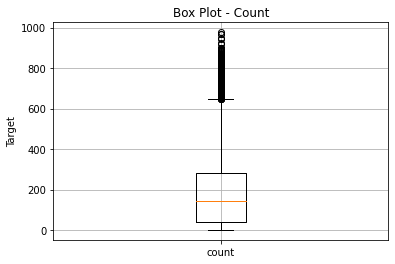

In [ ]:

plt.boxplot(df_train['count'], labels=['count'])

plt.title('Box Plot - Count')
plt.ylabel('Target')
plt.grid(True)
plt.show ()

In [ ]:
fig = px.box(df_train, y="count")
fig.show()

The Box plot shows that there are many outliers in the range [647, 977]. One possible way to reduce it will be to transform the features, altough not necessary for XGboost and any othet algorithms based on decision tree

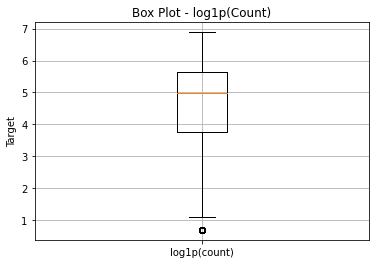

In [ ]:

# Let's see how the data distribution changes with log1p
# Evenly distributed
plt.boxplot([df_train['count'].map(np.log1p)], labels=['log1p(count)'])
plt.title('Box Plot - log1p(Count)')
plt.ylabel('Target')
plt.grid(True)

# df["count"] = df["count"].map(np.log1p)

The boxplot abobe shows how the outliers disapear with the logarithmic transformation

## Features Correlations

In [ ]:
df_train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


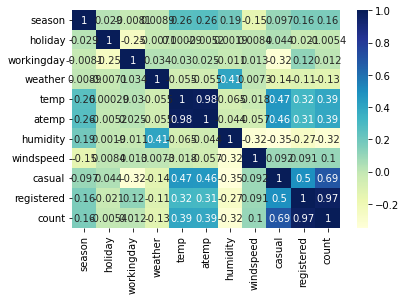

In [ ]:
import seaborn as sb
  
# plotting correlation heatmap
dataplot = sb.heatmap(df_train.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [ ]:
# fig = px.imshow(data_train.corr(),text_auto=True,aspect="auto")

# fig.show()

fig = px.imshow(df_train.corr(),text_auto=True,aspect="auto",
                labels=dict(x="Metrics", y="", color="Correlation"),
                # x=['Median Current', 'Median Voltage', 'Median Temp', 'Median SoC'],
                # y=['Median Current', 'Median Voltage', 'Median Temp', 'Median SoC'],
                color_continuous_scale='RdBu_r', 
               )
fig.update_xaxes(side="bottom")

fig.show()

In [ ]:
df_train.corr()["count"].sort_values(ascending=False)


count         1.000000
registered    0.970948
casual        0.690414
temp          0.394454
atemp         0.389784
season        0.163439
windspeed     0.101369
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

The hour of day positively affect the bike rental, while the humidity and weather negatively affect it. This was expected

# Data Preprocessing/Transformation

In [ ]:

def explode_datetime(df):
  """ This Function will explode the datetime field into year, month, day, dayofweak and hour """
  df['year'] = df.index.year
  df['month'] = df.index.month
  df['day'] = df.index.day
  df['dayofweek'] = df.index.dayofweek
  df['hour'] = df.index.hour
  return df

#Alternative to the function Abobe. But the function will be usefull later on

# df_train["year"] = df_train.reset_index()['datetime'].dt.year
# df_train["month"] = df_train.reset_index()['datetime'].dt.month
# df_train["day"] = df_train.reset_index()['datetime'].dt.day
# df_train["dayofweek"] = df_train.reset_index()['datetime'].dt.dayofweek
# df_train["hour"] = df_train.reset_index()['datetime'].dt.hour

## Drop datetime index and drop the unecessary columns

In [ ]:
# the test dataset does not have the column registers and casual. 
# That is why we are droping it here, But actually, it is a good decision factor.
# Without dropong it, the training error goes down quickly, without any need of data transformation abd scaling

columns_list = list(df_train.columns)

columns_to_remove = ["casual","registered"]

[columns_list.remove(i) for i in columns_to_remove]

#Remove casual and register from the training dataset
df_train = df_train[columns_list]

#Explode the datetime index using the function explode_datetime
df_train = explode_datetime(df_train)

#We also need to explode the datetime index for the test dataset.
df_test = explode_datetime(df_test)




print("df_train_new shape: ",df_train.shape)
print("df_test shape: ",df_test.shape)

df_train_new shape:  (10886, 14)
df_test shape:  (6493, 13)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:

# fig = px.box(df_train, x="year", y="count",points="all")
fig = px.box(df_train, x="year", y="count",color="hour")

fig.update_layout(plot_bgcolor = "white",title='Boxplot of counts split by years')

fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [ ]:

# fig = px.box(df_train, x="year", y="count",points="all")
fig = px.box(df_train, x="year", y="count",color="month")

fig.update_layout(plot_bgcolor = "white",title='Boxplot of counts split by years')

fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()


In [ ]:

# fig = px.box(df_train, x="year", y="count",points="all")
fig = px.box(df_train, x="year", y="count",color="holiday")

fig.update_layout(plot_bgcolor = "white",title='Boxplot of counts split by years')

fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()


In [ ]:

# fig = px.box(df_train, x="year", y="count",points="all")
fig = px.box(df_train, x="year", y="count",color="season",notched=True,hover_data=["holiday"]) # used notched shape)

fig.update_layout(plot_bgcolor = "white",title='Boxplot of counts split by years')

fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()



## Data Scaling

In [ ]:
# let's use the applymap module of pandas to transform all our dataser using log(1+x): np.log1p

df_train_scaled = df_train.applymap(np.log1p)

# Dont forget to apply the inverse transformation at the end of the study, when infering the prdictions
# df = df.applymap(np.expm1)

## Data Shuffling

This step is not required, but might sometime help speeding up the convergence of the traning. We will test both and see if it helps

In [ ]:
df_train_shuffle = df_train.sample(frac=1).reset_index(drop=False)

## Data Spliting

Split the training set and assign another part for validation

In [ ]:

from sklearn.model_selection import train_test_split

# X_train, X_validation, y_train, y_validation  = train_test_split(X, y, test_size = 0.2)

# df_train_new, df_validation = train_test_split(df_train,  test_size = 0.2)
df_train_new, df_validation = train_test_split(df_train,  test_size = 0.3)

df_train_scaled_new, df_validation_scaled = train_test_split(df_train_scaled,  test_size = 0.3)

df_train_new_shuffle, df_validation_shuffle = train_test_split(df_train_shuffle,  test_size = 0.3)

In [ ]:
#Get the features of the training dataset by dropping the target column
X_train = df_train_new.reset_index(drop=True).drop(["count"],axis=1) # Features: drop the last label column
#Get the target column of the training dataset 
y_train = df_train_new["count"].ravel() # Target. the .ravel extract only the values of the pandas Series

#Get the features of the validation dataset by dropping the target column
X_validation = df_validation.reset_index(drop=True).drop(["count"],axis=1) # Features: drop the last label column
#Get the target column of the validation dataset 
y_validation = df_validation["count"].ravel() # Target. the .ravel extract only the values of the pandas Series as an array

###########################3
#Shuffled Data
############################
X_train_shuffle = df_train_new_shuffle.reset_index(drop=True).drop(["count"],axis=1) # Features: drop the last label column
y_train_shuffle = df_train_new_shuffle["count"].ravel() # Target. the .ravel extract only the values of the pandas Series

X_validation_shuffle = df_validation_shuffle.reset_index(drop=True).drop(["count"],axis=1) # Features: drop the last label column
y_validation_shuffle = df_validation_shuffle["count"].ravel() # Target. the .ravel extract only the values of the pandas Series


###########################3
#scaledd Data
############################
X_train_scaled = df_train_scaled_new.reset_index(drop=True).drop(["count"],axis=1) # Features: drop the last label column
y_train_scaled = df_train_scaled_new["count"].ravel() # Target. the .ravel extract only the values of the pandas Series

X_validation_scaled = df_validation_scaled.reset_index(drop=True).drop(["count"],axis=1) # Features: drop the last label column
y_validation_scaled = df_validation_scaled["count"].ravel() # Target. the .ravel extract only the values of the pandas Series





# XGBOOST Algorithm Training

In [ ]:
# XGBoost Training Parameter Reference: 
# regressor = xgb.XGBRegressor(max_depth=15,subsample=0.5,num_round=1000)
regressor = xgb.XGBRegressor(max_depth=8, objective="reg:squarederror",  n_estimators=1000)
# regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0, 
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.2, max_delta_step=0, max_depth=6,
#              min_child_weight=1, 
#              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
#              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#              tree_method='exact', validate_parameters=1)
# 1



regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_validation, y_validation)])

[0]	validation_0-rmse:238.322	validation_1-rmse:241.257
[1]	validation_0-rmse:216.797	validation_1-rmse:219.41
[2]	validation_0-rmse:197.834	validation_1-rmse:200.191
[3]	validation_0-rmse:180.393	validation_1-rmse:182.703
[4]	validation_0-rmse:164.838	validation_1-rmse:167.216
[5]	validation_0-rmse:151.205	validation_1-rmse:153.551
[6]	validation_0-rmse:138.823	validation_1-rmse:141.208
[7]	validation_0-rmse:127.977	validation_1-rmse:130.441
[8]	validation_0-rmse:118.019	validation_1-rmse:120.567
[9]	validation_0-rmse:109.508	validation_1-rmse:112.228
[10]	validation_0-rmse:101.021	validation_1-rmse:103.824
[11]	validation_0-rmse:93.3469	validation_1-rmse:96.2783
[12]	validation_0-rmse:86.5199	validation_1-rmse:89.8283
[13]	validation_0-rmse:80.2678	validation_1-rmse:83.6193
[14]	validation_0-rmse:75.0432	validation_1-rmse:78.5405
[15]	validation_0-rmse:70.2585	validation_1-rmse:74.1209
[16]	validation_0-rmse:66.0057	validation_1-rmse:70.125
[17]	validation_0-rmse:62.2432	validation_1

XGBRegressor(max_depth=8, n_estimators=1000, objective='reg:squarederror')

The Training  root mean square error is 1.07 using 1000 trees and a max depth of 8, while the Validation root mean square error is 35.809. Let's plot the model evaluation root mean square error

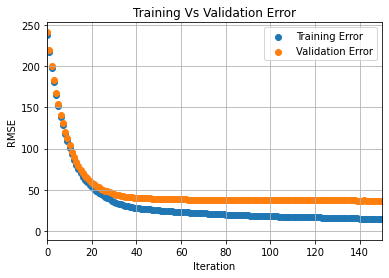

In [ ]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.xlim([0,150])
plt.show()

Both Validation and training error decreases and stall at some point. Adding more tree might help, but will consume more computer processing. We will check if we cannot have faster convergence using scaled features. But before that, let's check the most important features/predictors

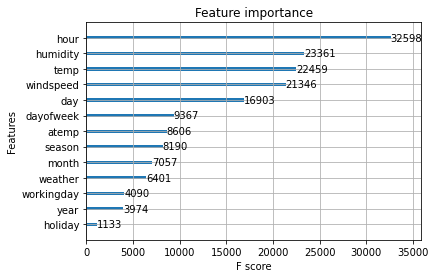

In [ ]:
xgb.plot_importance(regressor)
plt.show()

Hour, humidity and temperature are the top most factors that affect the number of bike rental

## Model Validation (Unscaled Data)

In [ ]:
prediction = regressor.predict(X_validation)
df_validation['count_predicted'] = prediction



In [ ]:
# Actual Vs Predicted
# plt.plot(df_validation['count'].reset_index(drop=True), label='Actual')
# plt.plot(df_validation['count_predicted'].reset_index(drop=True),label='Predicted')
# plt.xlabel('Sample')
# plt.ylabel('Count')
# # plt.xlim([100,150])
# # plt.ylim([0,800])

# plt.title('Validation Dataset - Predicted Vs. Actual')
# plt.legend()
# plt.show()

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

fig2 = make_subplots(specs=[[{"secondary_y": False}]])

# fig = px.scatter(df_2011.reset_index(), x='datetime', y='count', title='Time Series with Range Slider and Selectors')
# fig2 = px.scatter(df_validation.reset_index(), x='datetime', y='count_predicted', color="year", 
#                   title='Time Series with Range Slider and Selectors')


# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count'], 
#                          name="Actual",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='MediumPurple', width=2 )
#         ),),secondary_y=False)

fig2.add_trace(go.Scatter(x=df_validation.reset_index(drop=True).index.values, y=df_validation.reset_index()['count'], 
                         name="Actual",line=dict(color="black", width=3),),secondary_y=False)

fig2.add_trace(go.Scatter(x=df_validation.reset_index(drop=True).index.values, y=df_validation.reset_index()['count_predicted'], 
                         name="Prediction",line=dict(color="red", width=3),),secondary_y=False)

# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='red', width=2 )
#         ),),secondary_y=False)



# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",line=dict(color="red", width=3)),secondary_y=False)

    



# import plotly.express as px
# df = px.data.tips()
# fig = px.scatter(df, x="total_bill", y="tip", color="smoker",
#                  title="String 'smoker' values mean discrete colors")

# fig.show()
# #Hide Weekends
# fig.update_xaxes(
#     rangebreaks=[
#         dict(bounds=["sat", "mon"]), #hide weekends
#         # dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
#     ]
# )

fig2.update_xaxes(dict(ticks="inside", showgrid=False))
fig2.update_layout(plot_bgcolor = "white",title='Training')


fig2.show()

## Model Testing (Unscaled Data)



In [ ]:
# df_test.drop("count_predicted",axis=1,inplace=True)

# explode_datetime(data_test)

test_prediction = regressor.predict(df_test)
df_test['count_predict'] = test_prediction

df_test.to_csv("prediction_with_unscaled_data.csv")

In [ ]:



# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.express as px

# # df_test['count_predict']

fig3 = make_subplots(specs=[[{"secondary_y": False}]])

# fig3 = px.scatter(df_test.reset_index(), x='datetime', y='count_predict', title='Time Series with Range Slider and Selectors')

fig3.add_trace(go.Scatter(x=df_test.reset_index()['datetime'], y=df_test.reset_index()['count_predict'], 
                         name="Prediction",line=dict(color="darkgreen", width=3),),secondary_y=False)

fig3.add_trace(go.Scatter(x=df_train.reset_index()['datetime'], y=df_train.reset_index()['count'], 
                         name="Actual",line=dict(color="darkblue", width=1),),secondary_y=False)



# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='red', width=2 )
#         ),),secondary_y=False)



# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",line=dict(color="red", width=3)),secondary_y=False)

    



# import plotly.express as px
# df = px.data.tips()
# fig = px.scatter(df, x="total_bill", y="tip", color="smoker",
#                  title="String 'smoker' values mean discrete colors")

# fig.show()
# #Hide Weekends
# fig.update_xaxes(
#     rangebreaks=[
#         dict(bounds=["sat", "mon"]), #hide weekends
#         # dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
#     ]
# )

fig3.update_xaxes(dict(ticks="inside", showgrid=False))
fig3.update_layout(plot_bgcolor = "white")


fig3.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
             
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig3.show()


In [ ]:
fig3.update_xaxes(range=[10, 5])
fig3.update_yaxes(range=[-5, 300], autorange=False)
fig3.show()


#Effect of data shuffling

Let's keep the same number of trees and depth we previously had and check the effect of data shufling

In [ ]:
X_train_shuffle = X_train_shuffle.drop("datetime",axis=1)
X_validation_shuffle = X_validation_shuffle.drop("datetime",axis=1)

# regressor = xgb.XGBRegressor(max_depth=15,subsample=0.5,num_round=1000)
regressor = xgb.XGBRegressor(max_depth=8, objective="reg:squarederror",  n_estimators=1000)
#Q
regressor.fit(X_train_shuffle,y_train_shuffle, eval_set = [(X_train_shuffle, y_train_shuffle), (X_validation_shuffle, y_validation_shuffle)])

[0]	validation_0-rmse:238.42	validation_1-rmse:240.46
[1]	validation_0-rmse:216.742	validation_1-rmse:218.887
[2]	validation_0-rmse:197.743	validation_1-rmse:200.003
[3]	validation_0-rmse:180.504	validation_1-rmse:182.854
[4]	validation_0-rmse:165.328	validation_1-rmse:167.909
[5]	validation_0-rmse:151.291	validation_1-rmse:153.94
[6]	validation_0-rmse:139.033	validation_1-rmse:141.792
[7]	validation_0-rmse:127.613	validation_1-rmse:130.543
[8]	validation_0-rmse:117.892	validation_1-rmse:121.099
[9]	validation_0-rmse:108.866	validation_1-rmse:112.242
[10]	validation_0-rmse:100.386	validation_1-rmse:103.858
[11]	validation_0-rmse:92.8431	validation_1-rmse:96.5202
[12]	validation_0-rmse:86.0608	validation_1-rmse:90.0222
[13]	validation_0-rmse:80.1372	validation_1-rmse:84.3421
[14]	validation_0-rmse:74.6312	validation_1-rmse:79.1796
[15]	validation_0-rmse:69.9093	validation_1-rmse:74.7951
[16]	validation_0-rmse:65.6428	validation_1-rmse:70.8759
[17]	validation_0-rmse:61.6498	validation_1-

XGBRegressor(max_depth=8, n_estimators=1000, objective='reg:squarederror')

Shuffling didnt bring musch benefit in this project

#Effect of the Features Scaling

Let's keep the same number of trees and depth we previously had and check the effect of the scaling

In [ ]:
# regressor = xgb.XGBRegressor(max_depth=15,subsample=0.5,num_round=1000)
regressor_scaled = xgb.XGBRegressor(max_depth=8, objective="reg:squarederror",  n_estimators=1000)
#
regressor_scaled.fit(X_train_scaled,y_train_scaled, eval_set = [(X_train_scaled, y_train_scaled), (X_validation_scaled, y_validation_scaled)])

[0]	validation_0-rmse:3.90248	validation_1-rmse:3.91546
[1]	validation_0-rmse:3.52066	validation_1-rmse:3.53544
[2]	validation_0-rmse:3.17721	validation_1-rmse:3.19353
[3]	validation_0-rmse:2.86838	validation_1-rmse:2.88554
[4]	validation_0-rmse:2.59038	validation_1-rmse:2.60892
[5]	validation_0-rmse:2.34028	validation_1-rmse:2.35909
[6]	validation_0-rmse:2.11471	validation_1-rmse:2.13286
[7]	validation_0-rmse:1.91265	validation_1-rmse:1.93167
[8]	validation_0-rmse:1.7305	validation_1-rmse:1.75072
[9]	validation_0-rmse:1.56747	validation_1-rmse:1.58837
[10]	validation_0-rmse:1.42029	validation_1-rmse:1.44267
[11]	validation_0-rmse:1.28832	validation_1-rmse:1.31109
[12]	validation_0-rmse:1.17018	validation_1-rmse:1.19423
[13]	validation_0-rmse:1.064	validation_1-rmse:1.08909
[14]	validation_0-rmse:0.968397	validation_1-rmse:0.995128
[15]	validation_0-rmse:0.881037	validation_1-rmse:0.909344
[16]	validation_0-rmse:0.80321	validation_1-rmse:0.83303
[17]	validation_0-rmse:0.734504	validati

XGBRegressor(max_depth=8, n_estimators=1000, objective='reg:squarederror')

As we can see, the scaling of the feature has a great effect on the fast convergence of the model. With only <b>100 trees</b>, we could achieve a rmse of <b>0.14</b> for <b>training</b> and <b>0.28</b> for <b>validation</b>. Which is really small as compared to the <b>unscaled</b> data : 1.07019 (training) and 36.8144 (validation) after 1000 trees!

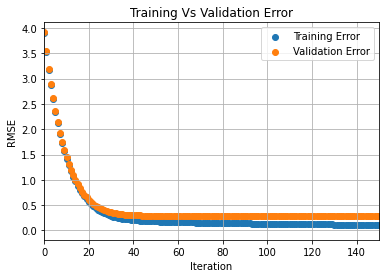

In [ ]:
eval_result = regressor_scaled.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.xlim([0,150])
plt.show()

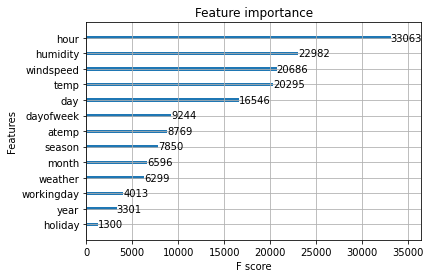

In [ ]:

xgb.plot_importance(regressor_scaled)
plt.show()

## Model Validation (Scaled Data)

In [ ]:
# df_validation_scaled.drop("count_predicted",axis=1,inplace=True)

In [ ]:
prediction = regressor_scaled.predict(X_validation_scaled)
df_validation_scaled['count_predicted_scaled'] = prediction


In [ ]:

# plt.title('Validation Dataset - Predicted Vs. Actual')
# plt.legend()
# plt.show()

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

fig2 = make_subplots(specs=[[{"secondary_y": False}]])

# fig = px.scatter(df_2011.reset_index(), x='datetime', y='count', title='Time Series with Range Slider and Selectors')
# fig2 = px.scatter(df_validation.reset_index(), x='datetime', y='count_predicted', color="year", 
#                   title='Time Series with Range Slider and Selectors')


# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count'], 
#                          name="Actual",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='MediumPurple', width=2 )
#         ),),secondary_y=False)

fig2.add_trace(go.Scatter(x=df_validation_scaled.reset_index(drop=True).index.values, y=df_validation_scaled.reset_index()['count'], 
                         name="Actual",line=dict(color="black", width=3),),secondary_y=False)

fig2.add_trace(go.Scatter(x=df_validation_scaled.reset_index(drop=True).index.values, y=df_validation_scaled.reset_index()['count_predicted_scaled'], 
                         name="Prediction",line=dict(color="red", width=3),),secondary_y=False)

# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='red', width=2 )
#         ),),secondary_y=False)



# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",line=dict(color="red", width=3)),secondary_y=False)

    



# import plotly.express as px
# df = px.data.tips()
# fig = px.scatter(df, x="total_bill", y="tip", color="smoker",
#                  title="String 'smoker' values mean discrete colors")

# fig.show()
# #Hide Weekends
# fig.update_xaxes(
#     rangebreaks=[
#         dict(bounds=["sat", "mon"]), #hide weekends
#         # dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
#     ]
# )

fig2.update_xaxes(dict(ticks="inside", showgrid=False))
fig2.update_layout(plot_bgcolor = "white",title='Model Validation: Unscaled Data')


fig2.show()

# df_test.drop("count_predicted",axis=1,inplace=True)



In [ ]:
df_validation_original = df_validation_scaled.applymap(np.expm1)


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

fig4 = make_subplots(specs=[[{"secondary_y": False}]])

# fig = px.scatter(df_2011.reset_index(), x='datetime', y='count', title='Time Series with Range Slider and Selectors')
# fig4 = px.scatter(df_validation.reset_index(), x='datetime', y='count_predicted', color="year", 
#                   title='Time Series with Range Slider and Selectors')


# fig4.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count'], 
#                          name="Actual",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='MediumPurple', width=2 )
#         ),),secondary_y=False)

fig4.add_trace(go.Scatter(x=df_validation_original.reset_index(drop=True).index.values, y=df_validation_original.reset_index()['count'], 
                         name="Actual",line=dict(color="black", width=3),),secondary_y=False)

fig4.add_trace(go.Scatter(x=df_validation_original.reset_index(drop=True).index.values, y=df_validation_original.reset_index()['count_predicted_scaled'], 
                         name="Prediction",line=dict(color="red", width=3),),secondary_y=False)

# fig4.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='red', width=2 )
#         ),),secondary_y=False)



# fig4.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",line=dict(color="red", width=3)),secondary_y=False)

    



# import plotly.express as px
# df = px.data.tips()
# fig = px.scatter(df, x="total_bill", y="tip", color="smoker",
#                  title="String 'smoker' values mean discrete colors")

# fig.show()
# #Hide Weekends
# fig.update_xaxes(
#     rangebreaks=[
#         dict(bounds=["sat", "mon"]), #hide weekends
#         # dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
#     ]
# )

fig4.update_xaxes(dict(ticks="inside", showgrid=False))
fig4.update_layout(plot_bgcolor = "white",title='Model Validation: Unscaled Data')


fig4.show()


## Model Testing (Scaled Data)



In [ ]:
# df = df_train_scaled.applymap(np.expm1)


In [ ]:


test_prediction = regressor_scaled.predict(explode_datetime(data_test))
df_test['count_predict_scaled'] = test_prediction



In [ ]:
df_train_true_scale = df_train_scaled.applymap(np.expm1) # Notice that since this is a Pandas DataFrame we use applymap here instead of just apply
df_test['count_predict_scaled_1000'] = df_test['count_predict_scaled'].apply(np.expm1) # Notice that since this is a Pandas Series we use apply here instead of applymap. We could also just use map

df_test.drop("count_predict_scaled",axis=1,inplace=True)

df_test.to_csv("prediction_scaled_and_unsecaled.csv")
df_test[[i for i in df_test.columns if i.startswith("count_predict")]]



,count_predict,count_predict_scaled_1000
datetime,,
2011-01-20 00:00:00,19.716640,17.739494
2011-01-20 01:00:00,4.915282,22.245865
2011-01-20 02:00:00,4.231406,56.368465
2011-01-20 03:00:00,-1.158683,111.295059
2011-01-20 04:00:00,-0.159085,51.393883
...,...,...
2012-12-31 19:00:00,224.082352,46.425076
2012-12-31 20:00:00,148.537354,46.425076
2012-12-31 21:00:00,118.100708,72.489250


In [ ]:



# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.express as px

# # df_test['count_predict']

fig5 = make_subplots(specs=[[{"secondary_y": False}]])

# fig5 = px.scatter(df_test.reset_index(), x='datetime', y='count_predict', title='Time Series with Range Slider and Selectors')

fig5.add_trace(go.Scatter(x=df_test.reset_index()['datetime'], y=df_test.reset_index()['count_predict_scaled_1000'], 
                         name="Prediction",line=dict(color="darkgreen", width=3),),secondary_y=False)

fig5.add_trace(go.Scatter(x=df_train_true_scale.reset_index()['datetime'], y=df_train_true_scale.reset_index()['count'], 
                         name="Actual",line=dict(color="darkblue", width=1),),secondary_y=False)



# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='red', width=2 )
#         ),),secondary_y=False)



# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",line=dict(color="red", width=3)),secondary_y=False)

    



# import plotly.express as px
# df = px.data.tips()
# fig = px.scatter(df, x="total_bill", y="tip", color="smoker",
#                  title="String 'smoker' values mean discrete colors")

# fig.show()
# #Hide Weekends
# fig.update_xaxes(
#     rangebreaks=[
#         dict(bounds=["sat", "mon"]), #hide weekends
#         # dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
#     ]
# )

fig5.update_xaxes(dict(ticks="inside", showgrid=False))
fig5.update_layout(plot_bgcolor = "white")


fig5.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
             
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig5.show()

The Scaled Method did not do a great job here for prediction, probably because it overfited the model! More investigation need to be carried out her!


In [ ]:
# regressor = xgb.XGBRegressor(max_depth=15,subsample=0.5,num_round=1000)
regressor_scaled = xgb.XGBRegressor(max_depth=5, objective="reg:squarederror",  n_estimators=25)
#
regressor_scaled.fit(X_train_scaled,y_train_scaled, eval_set = [(X_train_scaled, y_train_scaled), (X_validation_scaled, y_validation_scaled)])

[0]	validation_0-rmse:3.90397	validation_1-rmse:3.91683
[1]	validation_0-rmse:3.52478	validation_1-rmse:3.5383
[2]	validation_0-rmse:3.18376	validation_1-rmse:3.19797
[3]	validation_0-rmse:2.87777	validation_1-rmse:2.89249
[4]	validation_0-rmse:2.60163	validation_1-rmse:2.61743
[5]	validation_0-rmse:2.3542	validation_1-rmse:2.37068
[6]	validation_0-rmse:2.13242	validation_1-rmse:2.14891
[7]	validation_0-rmse:1.93325	validation_1-rmse:1.94999
[8]	validation_0-rmse:1.7557	validation_1-rmse:1.77274
[9]	validation_0-rmse:1.5962	validation_1-rmse:1.61373
[10]	validation_0-rmse:1.45275	validation_1-rmse:1.47064
[11]	validation_0-rmse:1.32367	validation_1-rmse:1.34134
[12]	validation_0-rmse:1.20884	validation_1-rmse:1.22584
[13]	validation_0-rmse:1.10802	validation_1-rmse:1.1257
[14]	validation_0-rmse:1.01214	validation_1-rmse:1.02901
[15]	validation_0-rmse:0.92974	validation_1-rmse:0.946943
[16]	validation_0-rmse:0.857784	validation_1-rmse:0.874986
[17]	validation_0-rmse:0.792931	validation_

XGBRegressor(max_depth=5, n_estimators=25, objective='reg:squarederror')

In [ ]:


test_prediction = regressor_scaled.predict(explode_datetime(data_test))
df_test['count_predict_scaled_150_trees_scaled'] = test_prediction

df_train_true_scale = df_train_scaled.applymap(np.expm1) # Notice that since this is a Pandas DataFrame we use applymap here instead of just apply
df_test['count_predict_scaled_150'] = df_test['count_predict_scaled_150_trees_scaled'].apply(np.expm1) # Notice that since this is a Pandas Series we use apply here instead of applymap. We could also just use map

df_test.drop("count_predict_scaled_150_trees_scaled",axis=1,inplace=True)

df_test.to_csv("prediction_scaled_and_unsecaled.csv")
df_test[[i for i in df_test.columns if i.startswith("count_predict")]]



,count_predict,count_predict_scaled_1000,count_predict_scaled_150
datetime,,,
2011-01-20 00:00:00,19.716640,17.739494,30.541765
2011-01-20 01:00:00,4.915282,22.245865,13.367253
2011-01-20 02:00:00,4.231406,56.368465,35.552277
2011-01-20 03:00:00,-1.158683,111.295059,187.831970
2011-01-20 04:00:00,-0.159085,51.393883,66.367592
...,...,...,...
2012-12-31 19:00:00,224.082352,46.425076,67.343529
2012-12-31 20:00:00,148.537354,46.425076,67.343529
2012-12-31 21:00:00,118.100708,72.489250,95.302422


In [ ]:


# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.express as px

# # df_test['count_predict']

fig5 = make_subplots(specs=[[{"secondary_y": False}]])

# fig5 = px.scatter(df_test.reset_index(), x='datetime', y='count_predict', title='Time Series with Range Slider and Selectors')

fig5.add_trace(go.Scatter(x=df_test.reset_index()['datetime'], y=df_test.reset_index()['count_predict_scaled_150'], 
                         name="Prediction",line=dict(color="darkgreen", width=3),),secondary_y=False)

fig5.add_trace(go.Scatter(x=df_train_true_scale.reset_index()['datetime'], y=df_train_true_scale.reset_index()['count'], 
                         name="Actual",line=dict(color="darkblue", width=1),),secondary_y=False)



# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",mode='markers', 
#                           marker=dict(color='LightSkyBlue',size=2, 
#                                       line=dict(color='red', width=2 )
#         ),),secondary_y=False)



# fig2.add_trace(go.Scatter(x=df_validation.reset_index()['datetime'], y=df_validation.reset_index()['count_predicted'], 
#                          name="Prediction",line=dict(color="red", width=3)),secondary_y=False)

    



# import plotly.express as px
# df = px.data.tips()
# fig = px.scatter(df, x="total_bill", y="tip", color="smoker",
#                  title="String 'smoker' values mean discrete colors")

# fig.show()
# #Hide Weekends
# fig.update_xaxes(
#     rangebreaks=[
#         dict(bounds=["sat", "mon"]), #hide weekends
#         # dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
#     ]
# )

fig5.update_xaxes(dict(ticks="inside", showgrid=False))
fig5.update_layout(plot_bgcolor = "white")


fig5.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
             
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig5.show()


In [ ]:
df_test.to_csv("tchamna_bike_prediction.csv")

# Exploration of other Machine Learning Algorithm

In [ ]:
#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification
 

In [ ]:
# regressor = xgb.XGBRegressor(max_depth=8, objective="reg:squarederror",  n_estimators=1000)

models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    test_pred=clf.predict(X_validation)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_validation)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   

In [ ]:
rmsle_frame=pd.DataFrame(d)
rmsle_frame

,Modelling Algo,RMSLE
0,RandomForestRegressor,0.336284
1,AdaBoostRegressor,1.129537
2,BaggingRegressor,0.351810
3,SVR,1.476332
4,KNeighborsRegressor,0.959386


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



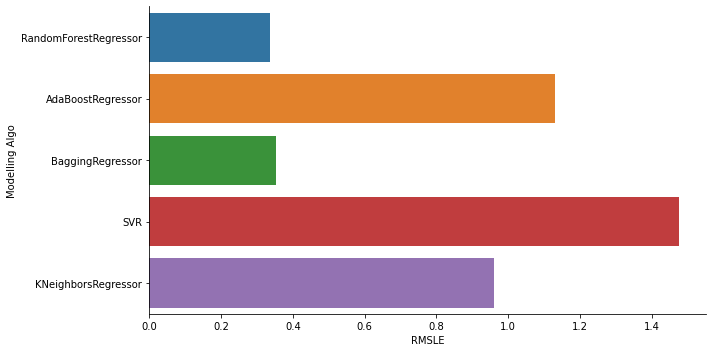

In [ ]:
sns.factorplot(y='Modelling Algo',x='RMSLE',data=rmsle_frame,kind='bar',size=5,aspect=2)


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



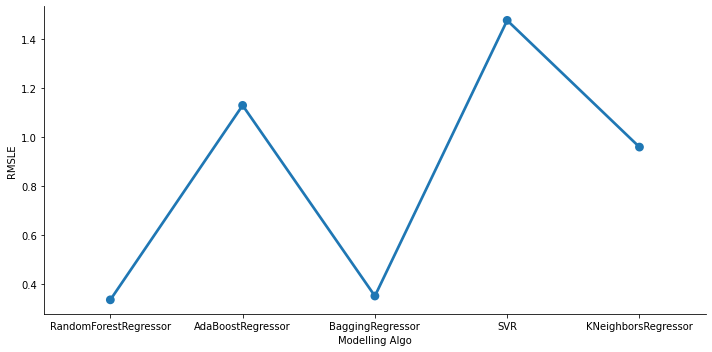

In [ ]:
sns.factorplot(x='Modelling Algo',y='RMSLE',data=rmsle_frame,kind='point',size=5,aspect=2)


In [ ]:
#for random forest regresion.
no_of_test=[500]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(X_train,y_train)
pred=clf_rf.predict(X_validation)
print((np.sqrt(mean_squared_log_error(pred,y_validation))))

0.33716942210848067


In [ ]:
clf_rf.best_params_


{'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1}

In [ ]:
test_df = df_test.reset_index().drop([i for i in df_test.columns if i.startswith("count")],axis=1)

pred=clf_rf.predict(test_df.drop('datetime',axis=1))
d={'datetime':df_test.reset_index()['datetime'],'count':pred}
ans=pd.DataFrame(d)
ans.to_csv('answer.csv',index=False) # saving to a csv file for predictions on kaggle.

In [ ]:
# for KNN
n_neighbors=[]
for i in range (0,50,5):
    if(i!=0):
        n_neighbors.append(i)
params_dict={'n_neighbors':n_neighbors,'n_jobs':[-1]}
clf_knn=GridSearchCV(estimator=KNeighborsRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_knn.fit(X_train,y_train)
pred=clf_knn.predict(X_validation)
print((np.sqrt(mean_squared_log_error(pred,y_validation))))

0.9593863584129364


In [ ]:
clf_knn.best_params_


{'n_jobs': -1, 'n_neighbors': 5}